<a href="https://colab.research.google.com/github/savannahshannon/bias/blob/main/bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIPAR-10

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix

# Model Hyperparameters
LATENT_DIM = 128
EPOCHS = 150
CLASSIFIER_EPOCHS = 50
BATCH_SIZE = 64
IMG_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# Define the class names for CIFAR-10 for better visualization
CIFAR10_CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_class_distribution(labels, title, class_names):
    """Helper function to plot the distribution of classes."""
    unique, counts = np.unique(labels, return_counts=True)
    class_map = {i: 0 for i in range(len(class_names))}
    for i, cls in enumerate(unique):
        class_map[cls] = counts[i]

    sorted_counts = [class_map[i] for i in range(len(class_names))]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names, y=sorted_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

# --- Step 1: Load and Preprocess Data ---
print("Step 1: Loading and preprocessing the CIFAR-10 dataset...")
(x_train_orig, y_train_orig), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train_orig = y_train_orig.flatten()
y_test = y_test.flatten()

# GANs work best with data normalized to the [-1, 1] range
x_train_gan_norm = (x_train_orig.astype('float32') - 127.5) / 127.5
print(f"Original training data shape: {x_train_gan_norm.shape}")
print(f"Test data shape: {x_test.shape}")

# --- Step 2: Artificially Create an Imbalanced Dataset ---
print("\nStep 2: Artificially creating an imbalanced dataset...")
# Keep fewer samples for higher class indices
keep_percentages = {i: (1.0 - i * 0.09) for i in range(10)}
x_train_imbalanced_list = []
y_train_imbalanced_list = []

for class_id in range(10):
    class_indices = np.where(y_train_orig == class_id)[0]
    num_to_keep = int(len(class_indices) * keep_percentages[class_id])
    keep_indices = np.random.choice(class_indices, size=num_to_keep, replace=False)
    x_train_imbalanced_list.append(x_train_gan_norm[keep_indices])
    y_train_imbalanced_list.append(y_train_orig[keep_indices])

x_train_imbalanced_gan_norm = np.concatenate(x_train_imbalanced_list, axis=0)
y_train_imbalanced = np.concatenate(y_train_imbalanced_list, axis=0)

print(f"Shape of imbalanced training data: {x_train_imbalanced_gan_norm.shape}")
plot_class_distribution(y_train_imbalanced, 'Artificially Imbalanced CIFAR-10 Distribution', CIFAR10_CLASS_NAMES)


# --- Step 3: Define the GAN Components ---
print("\nStep 3: Building the Generator and Discriminator models...")

# -- Generator --
def build_generator():
    latent_input = layers.Input(shape=(LATENT_DIM,))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(NUM_CLASSES, 50)(label_input)
    # Merge label and latent vector
    merged_input = layers.Concatenate()([latent_input, layers.Flatten()(label_embedding)])

    # Project and reshape
    model = layers.Dense(4 * 4 * 256, use_bias=False)(merged_input)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Reshape((4, 4, 256))(model)

    # Upsampling block 1: 4x4 -> 8x8
    model = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)

    # Upsampling block 2: 8x8 -> 16x16
    model = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)

    # Upsampling block 3: 16x16 -> 32x32
    # Final layer uses tanh activation to scale output to [-1, 1]
    output_image = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(model)

    return tf.keras.Model([latent_input, label_input], output_image)

# -- Discriminator --
def build_discriminator():
    image_input = layers.Input(shape=IMG_SHAPE)
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(NUM_CLASSES, 50)(label_input)
    label_embedding = layers.Dense(IMG_SHAPE[0] * IMG_SHAPE[1] * 1)(label_embedding)
    label_embedding = layers.Reshape((IMG_SHAPE[0], IMG_SHAPE[1], 1))(label_embedding)

    merged_input = layers.Concatenate()([image_input, label_embedding])

    # Downsampling block 1
    model = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merged_input)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Dropout(0.4)(model) # Increased dropout

    # Downsampling block 2
    model = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Dropout(0.4)(model) # Increased dropout

    # Downsampling block 3
    model = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Dropout(0.4)(model) # Increased dropout

    model = layers.Flatten()(model)
    validity = layers.Dense(1, activation='sigmoid')(model)
    return tf.keras.Model([image_input, label_input], validity)

# Create the models
generator = build_generator()
discriminator = build_discriminator()
#print(generator.summary()) # comment out to get rid of the summary table
#print(discriminator.summary())

# --- Step 4: Define Loss, Optimizers, and Training Step ---
print("\nStep 4: Defining loss, optimizers, and the training step function...")

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# The core training logic for one batch
@tf.function
def train_step(real_images, real_labels):
    noise = tf.random.normal([real_images.shape[0], LATENT_DIM])

    real_labels_smooth = tf.ones_like(discriminator([real_images, real_labels], training=False)) * 0.9

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, real_labels], training=True)

        real_output = discriminator([real_images, real_labels], training=True)
        fake_output = discriminator([generated_images, real_labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        real_loss = cross_entropy(real_labels_smooth, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# --- Step 5: Train the cGAN ---
print(f"\nStep 5: Training the cGAN for {EPOCHS} epochs...")

# Create a tf.data.Dataset for efficient training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_imbalanced_gan_norm, y_train_imbalanced)).shuffle(len(x_train_imbalanced_gan_norm)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0

    for image_batch, label_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch, label_batch)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        num_batches +=1

    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches

    print (f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec. Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')

print("cGAN Training complete.")
# --- Step 6: Generate Synthetic Data to Balance the Dataset ---
print("\nStep 6: Generating synthetic data to re-balance the dataset...")

class_counts = np.bincount(y_train_imbalanced, minlength=NUM_CLASSES)
majority_count = np.max(class_counts)
print(f"Majority class has {majority_count} samples. Balancing all classes to this count.")

# Denormalize the original imbalanced set to add it back
x_balanced_list = [(x_train_imbalanced_gan_norm * 127.5 + 127.5).astype(np.uint8)]
y_balanced_list = [y_train_imbalanced]

for class_id in range(NUM_CLASSES):
    current_count = class_counts[class_id]
    num_to_generate = majority_count - current_count

    if num_to_generate > 0:
        print(f"Generating {num_to_generate} new images for class '{CIFAR10_CLASS_NAMES[class_id]}'")

        # Prepare inputs for the generator
        noise = tf.random.normal([num_to_generate, LATENT_DIM])
        labels_to_generate = np.full(num_to_generate, class_id)

        # Convert labels_to_generate to a TensorFlow tensor
        labels_to_generate_tensor = tf.constant(labels_to_generate, dtype=tf.int32)

        # Generate images
        synthetic_images = generator([noise, labels_to_generate_tensor], training=False) # Pass the tensor

        # Denormalize images from [-1, 1] back to [0, 255]
        synthetic_images_denorm = (synthetic_images.numpy() * 127.5 + 127.5).astype(np.uint8)

        # Append to our balanced list
        x_balanced_list.append(synthetic_images_denorm)
        y_balanced_list.append(labels_to_generate)

# Create the final balanced dataset
x_train_balanced = np.concatenate(x_balanced_list, axis=0)
y_train_balanced = np.concatenate(y_balanced_list, axis=0)

print(f"\nShape of final balanced training data: {x_train_balanced.shape}")


# --- Step 7: Verify the Final Balanced Dataset ---
print("\nStep 7: Verifying the distribution of the final, balanced dataset...")
plot_class_distribution(y_train_balanced, 'Final Re-balanced CIFAR-10 Distribution (using cGAN)', CIFAR10_CLASS_NAMES)


# --- Step 8: Visualize Sample Generated Images ---
print("\nStep 8: Displaying some sample generated images...")

def show_generated_images(rows=5, cols=5):
    noise = tf.random.normal([rows * cols, LATENT_DIM])
    # Generate one image of each class for the first 10 spots, then random
    sampled_labels = np.array([i for i in range(NUM_CLASSES)] * ((rows*cols)//NUM_CLASSES) + [0]*((rows*cols)%NUM_CLASSES) )

    # Convert sampled_labels to a TensorFlow tensor
    sampled_labels_tensor = tf.constant(sampled_labels, dtype=tf.int32)

    generated_images = generator.predict([noise, sampled_labels_tensor]) # Pass the tensor
    generated_images = 0.5 * generated_images + 0.5 # Rescale to [0, 1] for plotting

    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(generated_images[cnt, :,:,:])
            axs[i,j].set_title(f"Gen: {CIFAR10_CLASS_NAMES[sampled_labels[cnt]]}")
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

show_generated_images()

# --- Step 9: Define the Classifier Model ---
print("\nStep 9: Defining a standard CNN classifier for evaluation...")
def build_classifier():
    model = tf.keras.Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'), layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'), layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'), layers.MaxPooling2D((2, 2)),
        layers.Flatten(), layers.Dense(128, activation='relu'), layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# def build_classifier():
#     model = tf.keras.Sequential([
#         layers.Input(shape=IMG_SHAPE),
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(NUM_CLASSES, activation='softmax')
#     ])
#     model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Helper function to plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Prepare data for classifier (normalize to [0, 1])
# We need to denormalize the [-1,1] imbalanced data first, then re-normalize to [0,1]
x_train_imbalanced_uint8 = ((x_train_imbalanced_gan_norm * 127.5) + 127.5).astype(np.uint8)
x_train_imbalanced_clf_norm = x_train_imbalanced_uint8 / 255.0
x_train_balanced_clf_norm = x_train_balanced / 255.0
x_test_clf_norm = x_test / 255.0

# --- Step 10: Train and Evaluate the BASELINE Model (on imbalanced data) ---
print(f"\nStep 10: Training BASELINE classifier for {CLASSIFIER_EPOCHS} epochs on Imbalanced data...")
baseline_classifier = build_classifier()
baseline_classifier.fit(
    x_train_imbalanced_clf_norm, y_train_imbalanced,
    epochs=CLASSIFIER_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_clf_norm, y_test),
    verbose=1
)
print("\n--- BASELINE MODEL EVALUATION ---")
y_pred_baseline = baseline_classifier.predict(x_test_clf_norm)
y_pred_classes_baseline = np.argmax(y_pred_baseline, axis=1)
print(classification_report(y_test, y_pred_classes_baseline, target_names=CIFAR10_CLASS_NAMES))
plot_confusion_matrix(y_test, y_pred_classes_baseline, CIFAR10_CLASS_NAMES, 'Baseline Model Confusion Matrix')


# --- Step 11: Train and Evaluate the FINAL Model (on balanced data) ---
print(f"\nStep 11: Training FINAL classifier for {CLASSIFIER_EPOCHS} epochs on GAN-BALANCED data...")
final_classifier = build_classifier()
final_classifier.fit(
    x_train_balanced_clf_norm, y_train_balanced,
    epochs=CLASSIFIER_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_clf_norm, y_test),
    verbose=1
)
print("\n--- FINAL MODEL EVALUATION ---")
y_pred_final = final_classifier.predict(x_test_clf_norm)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)
print(classification_report(y_test, y_pred_classes_final, target_names=CIFAR10_CLASS_NAMES))
plot_confusion_matrix(y_test, y_pred_classes_final, CIFAR10_CLASS_NAMES, 'Final Model (GAN-Balanced) Confusion Matrix')

print("\nEvaluation complete. Compare the two classification reports.")

# CIPAR-100

Step 1: Loading and preprocessing the CIFAR-100 dataset...
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Original training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)

Step 2: Artificially creating an imbalanced dataset...
Shape of imbalanced training data: (27700, 32, 32, 3)


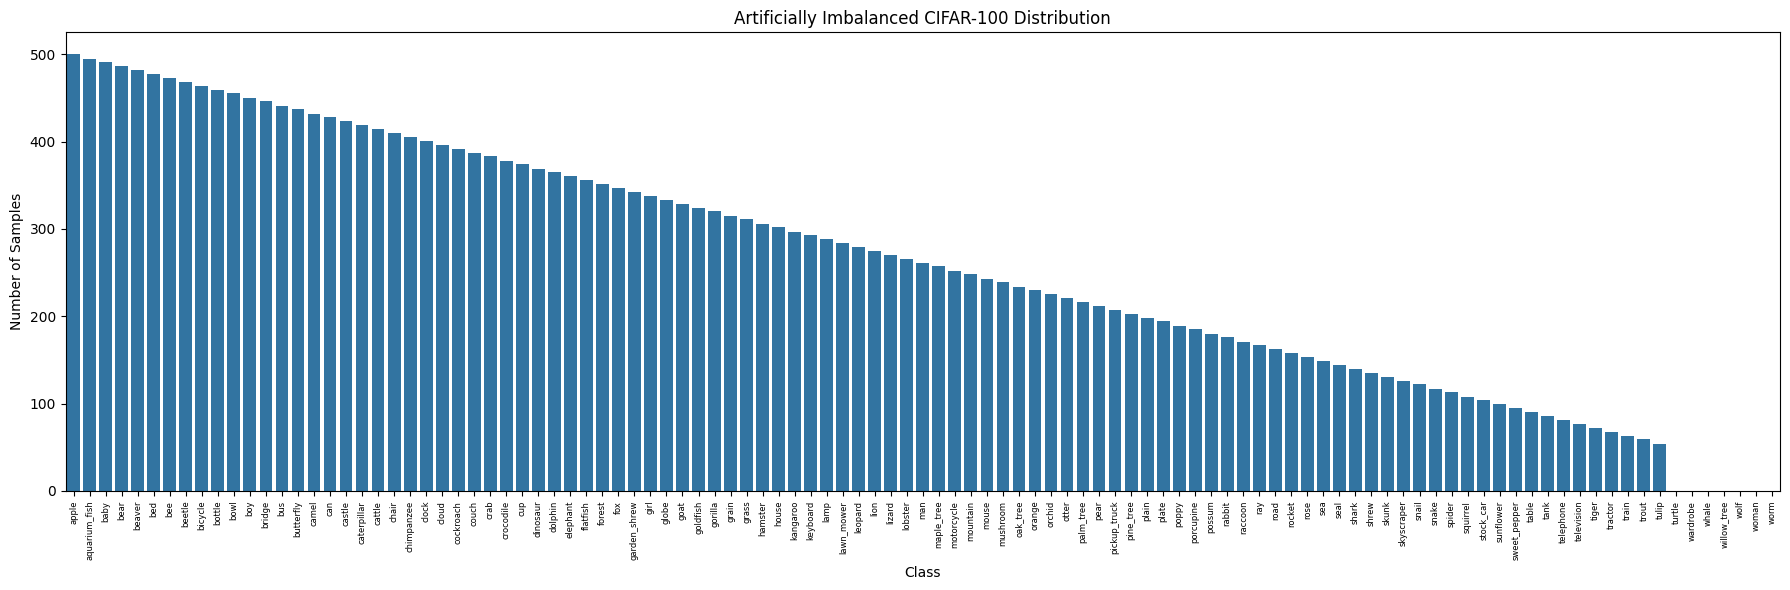


Step 3: Building the Generator and Discriminator models...

Step 4: Defining loss, optimizers, and the training step function...

Step 5: Training the cGAN for 150 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Time for epoch 1 is 186.40 sec. Gen Loss: 2.2295, Disc Loss: 0.8877
Time for epoch 2 is 201.91 sec. Gen Loss: 2.0876, Disc Loss: 0.9062


In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix

# Model Hyperparameters
LATENT_DIM = 128
EPOCHS = 150 # Reduced for quicker execution, can be increased
CLASSIFIER_EPOCHS = 50 # Reduced for quicker execution, can be increased
BATCH_SIZE = 64
IMG_SHAPE = (32, 32, 3)
NUM_CLASSES = 100 # Changed for CIFAR-100

# Define the class names for CIFAR-100 for better visualization
# Source: https://www.cs.toronto.edu/~kriz/cifar.html
CIFAR100_CLASS_NAMES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'garden_shrew', 'girl',
    'globe', 'goat', 'goldfish', 'gorilla', 'grain', 'grass', 'hamster', 'house',
    'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard',
    'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit',
    'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'stock_car',
    'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television',
    'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale',
    'willow_tree', 'wolf', 'woman', 'worm'
]

def plot_class_distribution(labels, title, class_names):
    """Helper function to plot the distribution of classes."""
    unique, counts = np.unique(labels, return_counts=True)
    class_map = {i: 0 for i in range(len(class_names))}
    for i, cls in enumerate(unique):
        class_map[cls] = counts[i]

    sorted_counts = [class_map[i] for i in range(len(class_names))]

    plt.figure(figsize=(18, 6)) # Increased figure size for 100 classes
    sns.barplot(x=class_names, y=sorted_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=90, fontsize=6) # Rotate and shrink labels
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

# --- Step 1: Load and Preprocess Data ---
print("Step 1: Loading and preprocessing the CIFAR-100 dataset...")
(x_train_orig, y_train_orig), (x_test, y_test) = tf.keras.datasets.cifar100.load_data() # Changed to cifar100
y_train_orig = y_train_orig.flatten()
y_test = y_test.flatten()

# GANs work best with data normalized to the [-1, 1] range
x_train_gan_norm = (x_train_orig.astype('float32') - 127.5) / 127.5
print(f"Original training data shape: {x_train_gan_norm.shape}")
print(f"Test data shape: {x_test.shape}")

# --- Step 2: Artificially Create an Imbalanced Dataset ---
print("\nStep 2: Artificially creating an imbalanced dataset...")
# Keep fewer samples for higher class indices - adjusted for 100 classes
# Using a slower decay to ensure some classes remain for all 100
keep_percentages = {i: (1.0 - i * 0.009) for i in range(NUM_CLASSES)}
# Ensure no class has less than 10% of its original samples
for i in range(NUM_CLASSES):
    if keep_percentages[i] < 0.1:
        keep_percentages[i] = 0.1

x_train_imbalanced_list = []
y_train_imbalanced_list = []

for class_id in range(NUM_CLASSES):
    class_indices = np.where(y_train_orig == class_id)[0]
    num_to_keep = int(len(class_indices) * keep_percentages[class_id])
    keep_indices = np.random.choice(class_indices, size=num_to_keep, replace=False)
    x_train_imbalanced_list.append(x_train_gan_norm[keep_indices])
    y_train_imbalanced_list.append(y_train_orig[keep_indices])

x_train_imbalanced_gan_norm = np.concatenate(x_train_imbalanced_list, axis=0)
y_train_imbalanced = np.concatenate(y_train_imbalanced_list, axis=0)

print(f"Shape of imbalanced training data: {x_train_imbalanced_gan_norm.shape}")
plot_class_distribution(y_train_imbalanced, 'Artificially Imbalanced CIFAR-100 Distribution', CIFAR100_CLASS_NAMES)


# --- Step 3: Define the GAN Components ---
print("\nStep 3: Building the Generator and Discriminator models...")

# -- Generator --
def build_generator():
    latent_input = layers.Input(shape=(LATENT_DIM,))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(NUM_CLASSES, 100)(label_input) # Embedding dimension increased for 100 classes
    # Merge label and latent vector
    merged_input = layers.Concatenate()([latent_input, layers.Flatten()(label_embedding)])

    # Project and reshape
    model = layers.Dense(4 * 4 * 256, use_bias=False)(merged_input)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Reshape((4, 4, 256))(model)

    # Upsampling block 1: 4x4 -> 8x8
    model = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)

    # Upsampling block 2: 8x8 -> 16x16
    model = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)

    # Upsampling block 3: 16x16 -> 32x32
    # Final layer uses tanh activation to scale output to [-1, 1]
    output_image = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(model)

    return tf.keras.Model([latent_input, label_input], output_image)

# -- Discriminator --
def build_discriminator():
    image_input = layers.Input(shape=IMG_SHAPE)
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(NUM_CLASSES, 100)(label_input) # Embedding dimension increased for 100 classes
    label_embedding = layers.Dense(IMG_SHAPE[0] * IMG_SHAPE[1] * 1)(label_embedding) # Adjust dense layer output size
    label_embedding = layers.Reshape((IMG_SHAPE[0], IMG_SHAPE[1], 1))(label_embedding)

    merged_input = layers.Concatenate()([image_input, label_embedding])

    # Downsampling block 1
    model = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merged_input)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Dropout(0.4)(model) # Increased dropout

    # Downsampling block 2
    model = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Dropout(0.4)(model) # Increased dropout

    # Downsampling block 3
    model = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.2)(model)
    model = layers.Dropout(0.4)(model) # Increased dropout

    model = layers.Flatten()(model)
    validity = layers.Dense(1, activation='sigmoid')(model)
    return tf.keras.Model([image_input, label_input], validity)

# Create the models
generator = build_generator()
discriminator = build_discriminator()
#print(generator.summary()) # comment out to get rid of the summary table
#print(discriminator.summary())

# --- Step 4: Define Loss, Optimizers, and Training Step ---
print("\nStep 4: Defining loss, optimizers, and the training step function...")

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# The core training logic for one batch
@tf.function
def train_step(real_images, real_labels):
    noise = tf.random.normal([real_images.shape[0], LATENT_DIM])

    real_labels_smooth = tf.ones_like(discriminator([real_images, real_labels], training=False)) * 0.9

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, real_labels], training=True)

        real_output = discriminator([real_images, real_labels], training=True)
        fake_output = discriminator([generated_images, real_labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        real_loss = cross_entropy(real_labels_smooth, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# --- Step 5: Train the cGAN ---
print(f"\nStep 5: Training the cGAN for {EPOCHS} epochs...")

# Create a tf.data.Dataset for efficient training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_imbalanced_gan_norm, y_train_imbalanced)).shuffle(len(x_train_imbalanced_gan_norm)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0

    for image_batch, label_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch, label_batch)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        num_batches +=1

    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches

    print (f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec. Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')

print("cGAN Training complete.")
# --- Step 6: Generate Synthetic Data to Balance the Dataset ---
print("\nStep 6: Generating synthetic data to re-balance the dataset...")

class_counts = np.bincount(y_train_imbalanced, minlength=NUM_CLASSES)
majority_count = np.max(class_counts)
print(f"Majority class has {majority_count} samples. Balancing all classes to this count.")

# Denormalize the original imbalanced set to add it back
x_balanced_list = [(x_train_imbalanced_gan_norm * 127.5 + 127.5).astype(np.uint8)]
y_balanced_list = [y_train_imbalanced]

for class_id in range(NUM_CLASSES):
    current_count = class_counts[class_id]
    num_to_generate = majority_count - current_count

    if num_to_generate > 0:
        print(f"Generating {num_to_generate} new images for class '{CIFAR100_CLASS_NAMES[class_id]}' (Class ID: {class_id})")

        # Prepare inputs for the generator
        noise = tf.random.normal([num_to_generate, LATENT_DIM])
        labels_to_generate = np.full(num_to_generate, class_id)

        # Convert labels_to_generate to a TensorFlow tensor
        labels_to_generate_tensor = tf.constant(labels_to_generate, dtype=tf.int32)

        # Generate images
        synthetic_images = generator([noise, labels_to_generate_tensor], training=False) # Pass the tensor

        # Denormalize images from [-1, 1] back to [0, 255]
        synthetic_images_denorm = (synthetic_images.numpy() * 127.5 + 127.5).astype(np.uint8)

        # Append to our balanced list
        x_balanced_list.append(synthetic_images_denorm)
        y_balanced_list.append(labels_to_generate)

# Create the final balanced dataset
x_train_balanced = np.concatenate(x_balanced_list, axis=0)
y_train_balanced = np.concatenate(y_balanced_list, axis=0)

print(f"\nShape of final balanced training data: {x_train_balanced.shape}")


# --- Step 7: Verify the Final Balanced Dataset ---
print("\nStep 7: Verifying the distribution of the final, balanced dataset...")
plot_class_distribution(y_train_balanced, 'Final Re-balanced CIFAR-100 Distribution (using cGAN)', CIFAR100_CLASS_NAMES)


# --- Step 8: Visualize Sample Generated Images ---
print("\nStep 8: Displaying some sample generated images...")

def show_generated_images(rows=10, cols=10): # Changed to 10x10 for 100 classes
    noise = tf.random.normal([rows * cols, LATENT_DIM])
    # Generate one image of each class for the first 100 spots
    sampled_labels = np.array([i for i in range(NUM_CLASSES)])

    # Convert sampled_labels to a TensorFlow tensor
    sampled_labels_tensor = tf.constant(sampled_labels, dtype=tf.int32)

    generated_images = generator.predict([noise, sampled_labels_tensor]) # Pass the tensor
    generated_images = 0.5 * generated_images + 0.5 # Rescale to [0, 1] for plotting

    fig, axs = plt.subplots(rows, cols, figsize=(20,20)) # Increased figure size
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            if cnt < NUM_CLASSES: # Only plot up to NUM_CLASSES
                axs[i,j].imshow(generated_images[cnt, :,:,:])
                axs[i,j].set_title(f"Gen: {CIFAR100_CLASS_NAMES[sampled_labels[cnt]]}", fontsize=8) # Smaller font for title
                axs[i,j].axis('off')
            else:
                axs[i,j].axis('off') # Hide extra subplots if NUM_CLASSES < rows*cols
            cnt += 1
    plt.tight_layout()
    plt.show()

show_generated_images()

# --- Step 9: Define the Classifier Model ---
print("\nStep 9: Defining a standard CNN classifier for evaluation...")
def build_classifier():
    model = tf.keras.Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'), layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'), layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'), layers.MaxPooling2D((2, 2)),
        layers.Flatten(), layers.Dense(256, activation='relu'), layers.Dropout(0.5), # Increased Dense layer size
        layers.Dense(NUM_CLASSES, activation='softmax') # Changed for 100 classes
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Helper function to plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(25, 25)) # Increased figure size for 100 classes
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', # Turned off annot for readability with 100 classes
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=90, fontsize=4)
    plt.yticks(rotation=0, fontsize=4)
    plt.tight_layout()
    plt.show()

# Prepare data for classifier (normalize to [0, 1])
# We need to denormalize the [-1,1] imbalanced data first, then re-normalize to [0,1]
x_train_imbalanced_uint8 = ((x_train_imbalanced_gan_norm * 127.5) + 127.5).astype(np.uint8)
x_train_imbalanced_clf_norm = x_train_imbalanced_uint8 / 255.0
x_train_balanced_clf_norm = x_train_balanced / 255.0
x_test_clf_norm = x_test / 255.0

# --- Step 10: Train and Evaluate the BASELINE Model (on imbalanced data) ---
print(f"\nStep 10: Training BASELINE classifier for {CLASSIFIER_EPOCHS} epochs on Imbalanced data...")
baseline_classifier = build_classifier()
baseline_classifier.fit(
    x_train_imbalanced_clf_norm, y_train_imbalanced,
    epochs=CLASSIFIER_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_clf_norm, y_test),
    verbose=1
)
print("\n--- BASELINE MODEL EVALUATION ---")
y_pred_baseline = baseline_classifier.predict(x_test_clf_norm)
y_pred_classes_baseline = np.argmax(y_pred_baseline, axis=1)
print(classification_report(y_test, y_pred_classes_baseline, target_names=CIFAR100_CLASS_NAMES))
plot_confusion_matrix(y_test, y_pred_classes_baseline, CIFAR100_CLASS_NAMES, 'Baseline Model Confusion Matrix')


# --- Step 11: Train and Evaluate the FINAL Model (on balanced data) ---
print(f"\nStep 11: Training FINAL classifier for {CLASSIFIER_EPOCHS} epochs on GAN-BALANCED data...")
final_classifier = build_classifier()
final_classifier.fit(
    x_train_balanced_clf_norm, y_train_balanced,
    epochs=CLASSIFIER_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_clf_norm, y_test),
    verbose=1
)
print("\n--- FINAL MODEL EVALUATION ---")
y_pred_final = final_classifier.predict(x_test_clf_norm)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)
print(classification_report(y_test, y_pred_classes_final, target_names=CIFAR100_CLASS_NAMES))
plot_confusion_matrix(y_test, y_pred_classes_final, CIFAR100_CLASS_NAMES, 'Final Model (GAN-Balanced) Confusion Matrix')

print("\nEvaluation complete. Compare the two classification reports.")